First let load all csvs

In [31]:
import pandas as pd
import csv
import numpy as np



In [32]:
inv  = pd.read_csv('data/Invoice.csv')

In [33]:
pin = pd.read_csv('data/pincodes.csv')

In [34]:
repo = pd.read_csv('data/order report.csv')

In [35]:
rates = pd.read_csv('data/Courier Company - Rates.csv')

In [36]:
master = pd.read_csv('data/SKU Master.csv')

Check if there are any missing values

In [37]:
import missingno as msno

<Axes: >

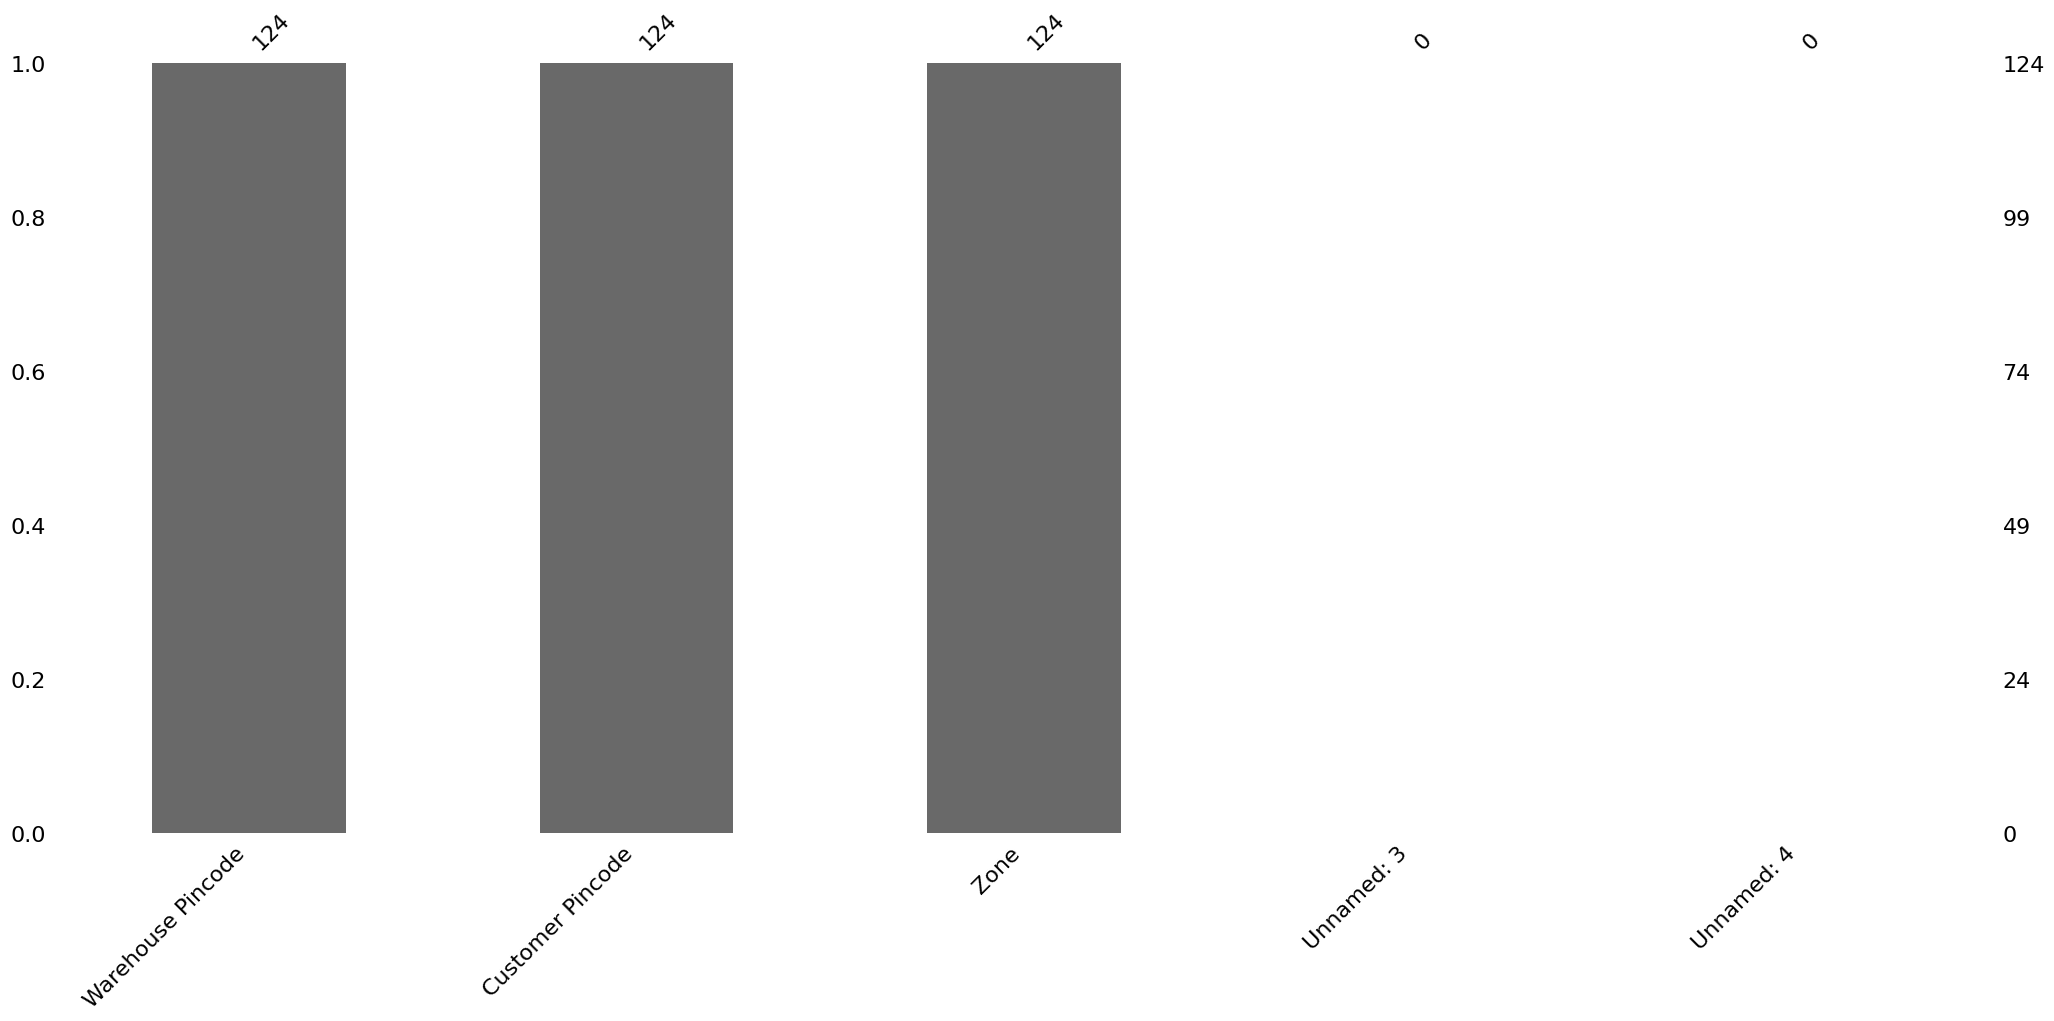

In [38]:
# msno.bar(master)
# msno.bar(inv)
# msno.bar(rates)
# msno.bar(repo)
msno.bar(pin)

In [39]:
# drop last 3 columns in master df
df_master = master.iloc[:, :-3]
# drop last 2 columns in repo df
df_repo = repo.iloc[:,:-2]
# drop last 2 colums in pin df
df_pin = pin.iloc[:,:-2]

<Axes: >

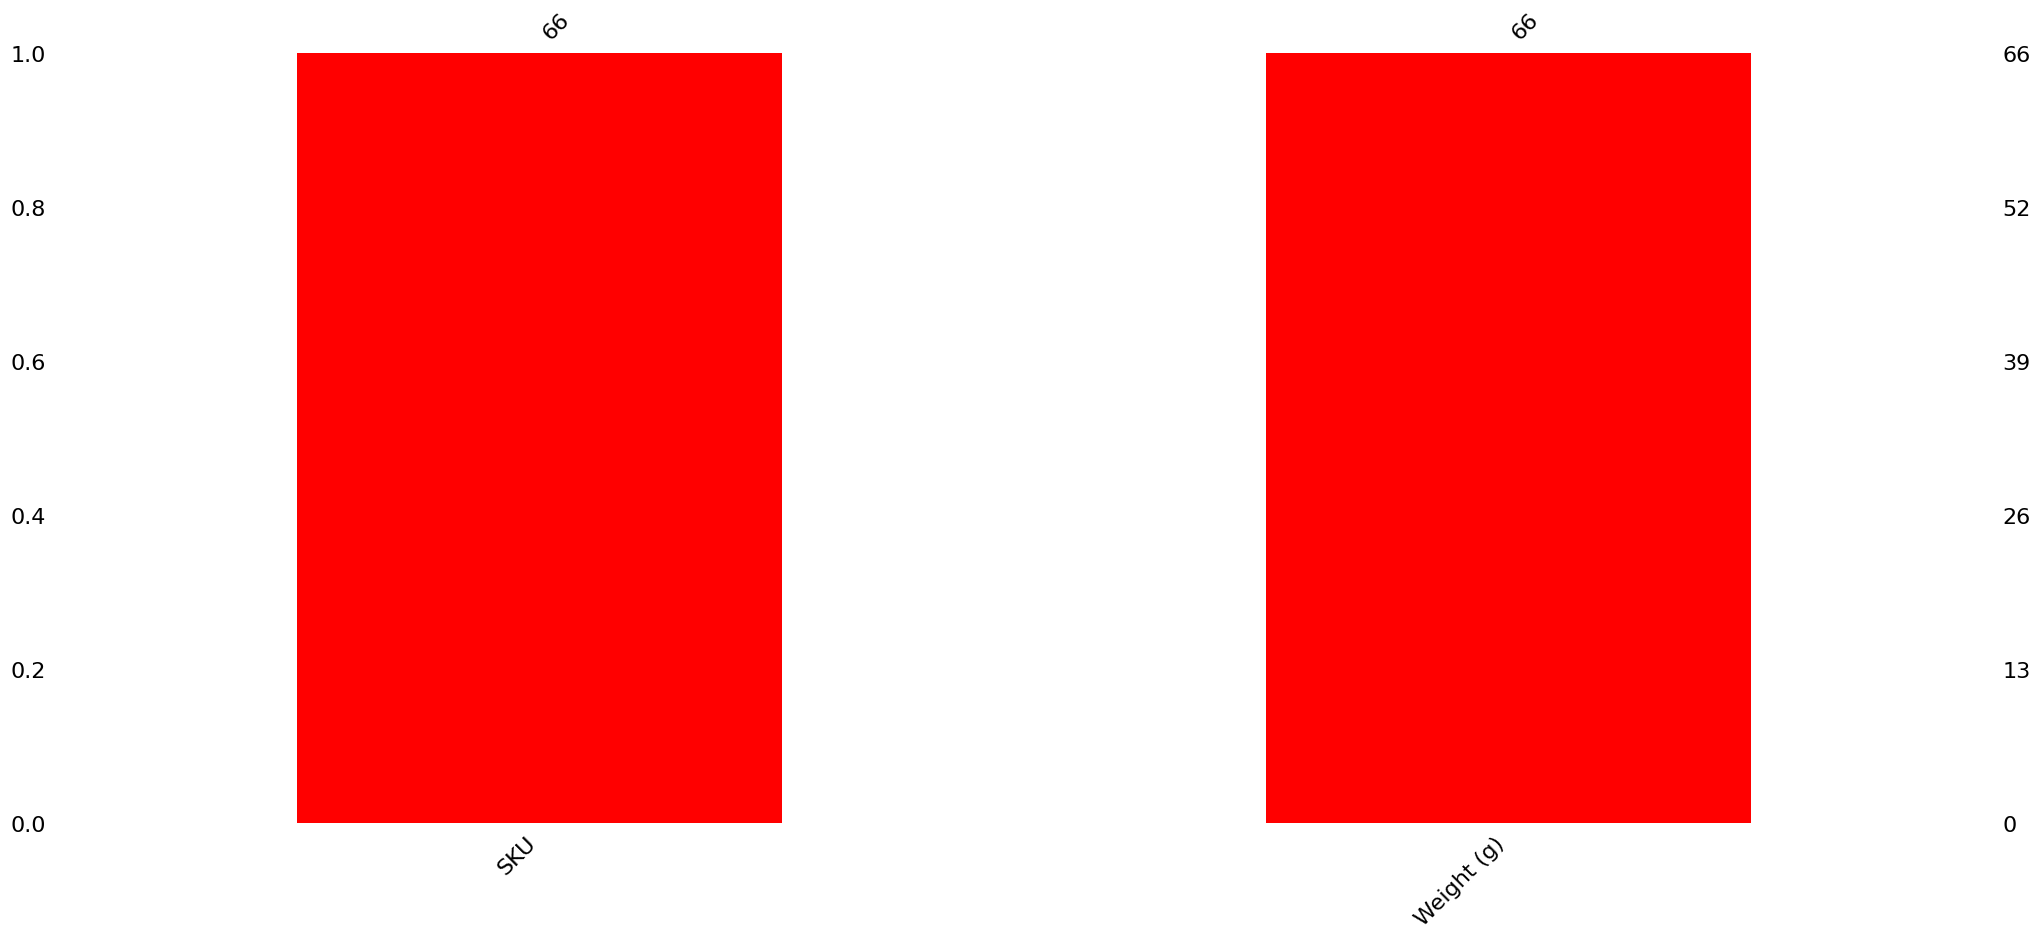

In [40]:
msno.bar(df_master, color='r')

<Axes: >

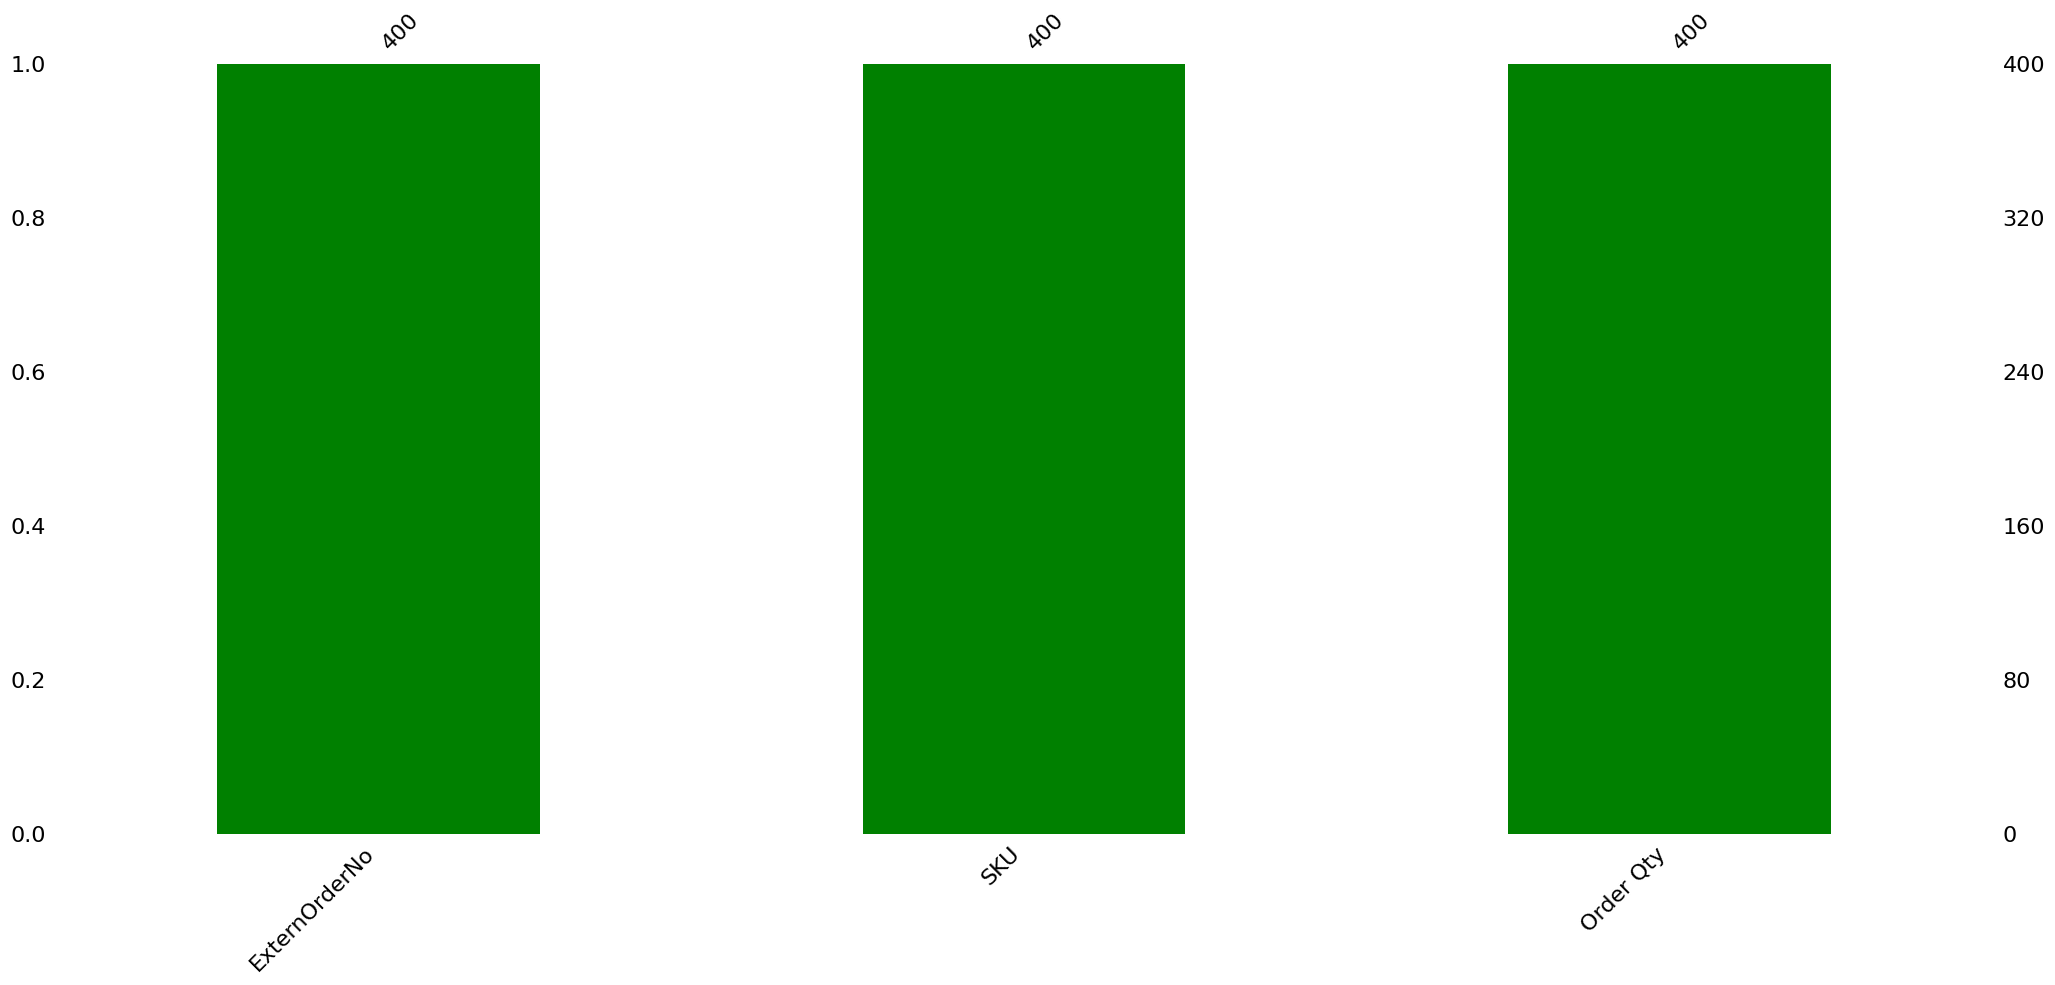

In [41]:
msno.bar(df_repo, color='g')

<Axes: >

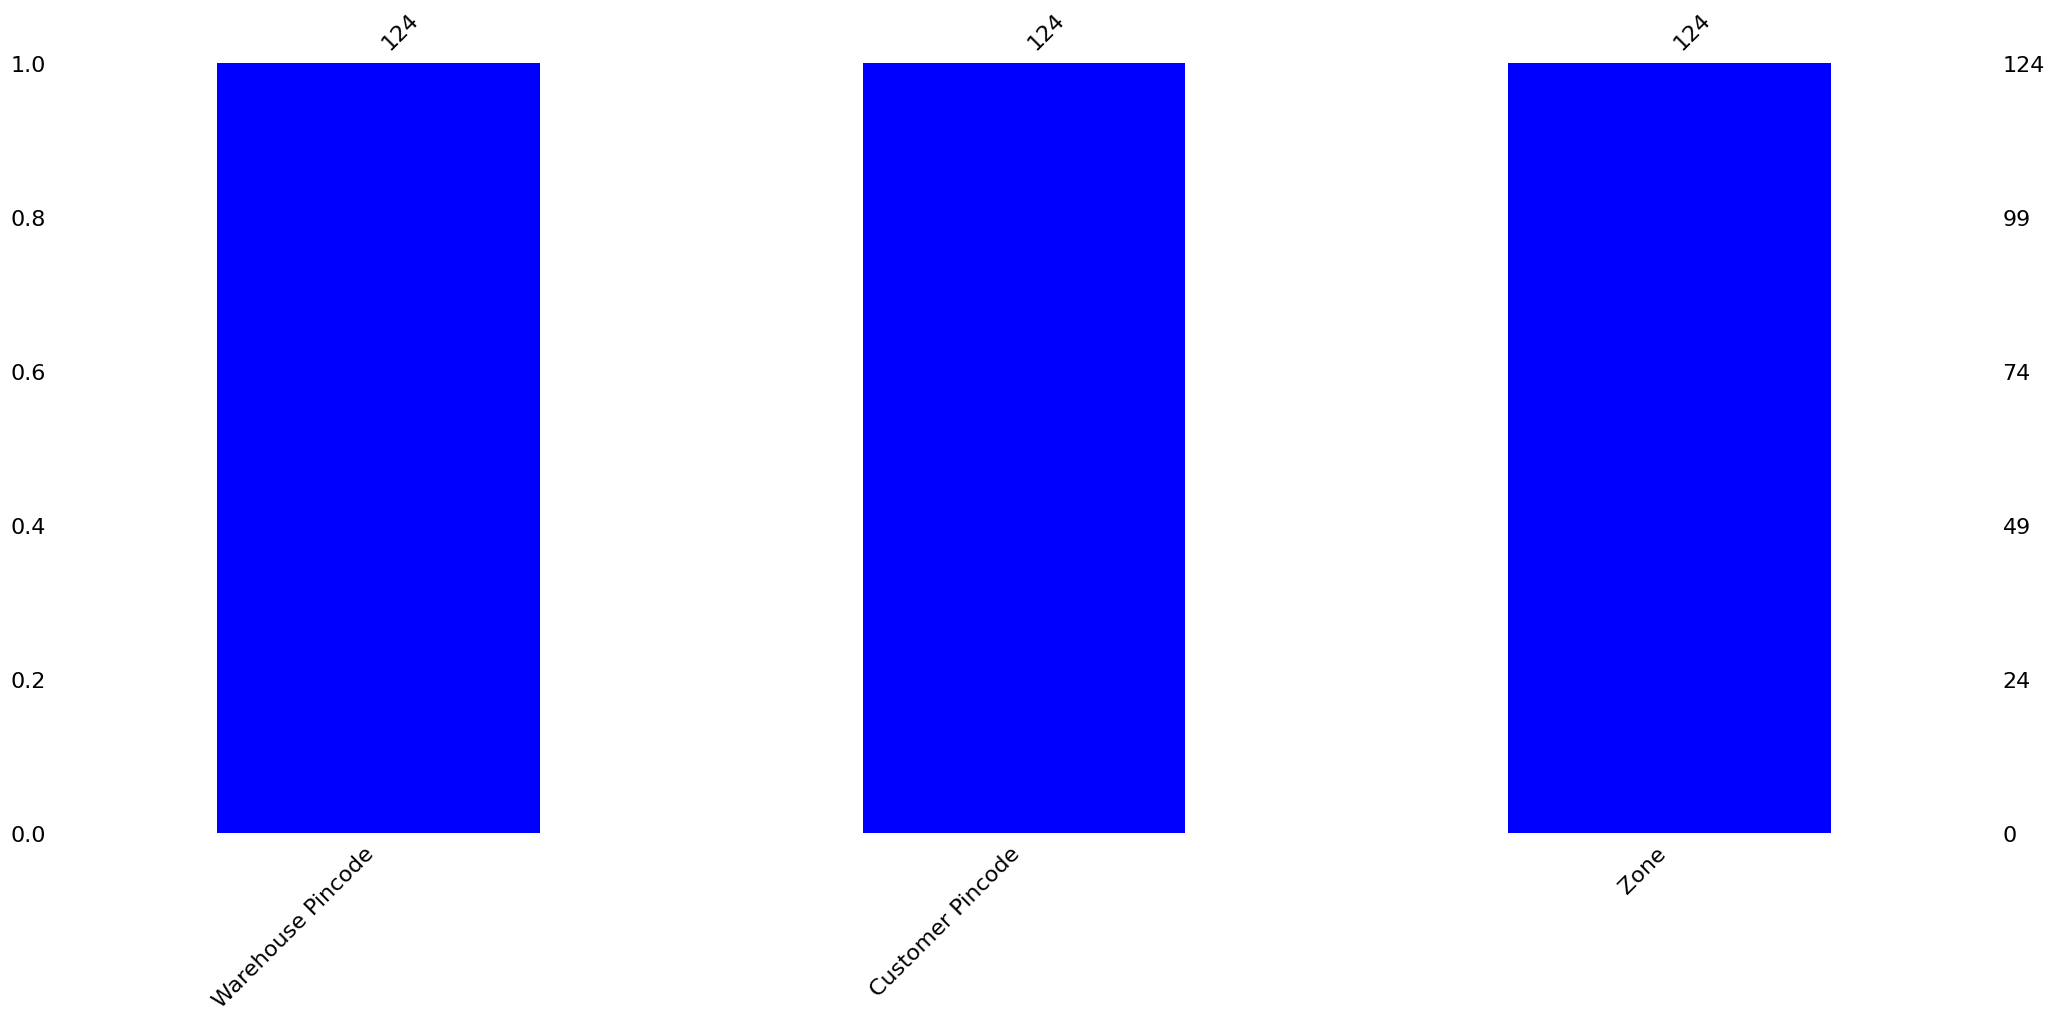

In [42]:
msno.bar(df_pin, color='b')

In [43]:
# Merge the Order Report and SKU Master based on SKU
merged_data = pd.merge(df_repo, df_master, on='SKU')
merged_data.head()


,ExternOrderNo,SKU,Order Qty,Weight (g)
0,2001827036,8904223818706,1.0,127
1,2001827036,8904223819093,1.0,150
2,2001827036,8904223819109,1.0,100
3,2001827036,8904223818430,1.0,165
4,2001827036,8904223819277,1.0,350


In [44]:
# Rename the "ExternOrderNo" column to "Order ID" in the merged_data DataFrame
merged_data = merged_data.rename(columns={'ExternOrderNo': 'Order ID'})

In [45]:
merged_data.head()

,Order ID,SKU,Order Qty,Weight (g)
0,2001827036,8904223818706,1.0,127
1,2001827036,8904223819093,1.0,150
2,2001827036,8904223819109,1.0,100
3,2001827036,8904223818430,1.0,165
4,2001827036,8904223819277,1.0,350


In [46]:
# drop dupliactes in pincodes
df_pin = df_pin.drop_duplicates(subset=['Customer Pincode'])

In [47]:
#  courier invoice and pincode mapping dataset
courier_abc= inv[['Order ID', 'Customer Pincode','Type of Shipment']]
pincodes= courier_abc.merge(df_pin,on='Customer Pincode')

In [48]:
# merge both merged dfs
merged2 = merged_data.merge(pincodes, on='Order ID')

In [49]:
merged2['Weights (Kgs)'] = merged2['Weight (g)'] / 1000

In [50]:
def weight_slab(weight):
    i = round(weight % 1, 1)
    if i == 0.0:
        return weight
    elif i > 0.5:
        return int(weight) + 1.0
    else:
        return int(weight) + 0.5

In [51]:
merged2['Weight Slab (KG)'] = merged2['Weights (Kgs)'].apply(weight_slab)

In [52]:
inv['Weight Slab Charged by Courier Company']=(inv['Charged Weight']).apply(weight_slab)

In [53]:
inv = inv.rename(columns={'Zone': 'Delivery Zone Charged by Courier Company'})
merged2 = merged2.rename(columns={'Zone': 'Delivery Zone As Per ABC'})
merged2 = merged2.rename(columns={'Weight Slab (KG)': 'Weight Slab As Per ABC'})

In [54]:
total_expected_charge = []

for _, row in merged2.iterrows():
    fwd_category = 'fwd_' + row['Delivery Zone As Per ABC']
    fwd_fixed = rates.at[0, fwd_category + '_fixed']
    fwd_additional = rates.at[0, fwd_category + '_additional']
    rto_category = 'rto_' + row['Delivery Zone As Per ABC']
    rto_fixed = rates.at[0, rto_category + '_fixed']
    rto_additional = rates.at[0, rto_category + '_additional']

    weight_slab = row['Weight Slab As Per ABC']

    if row['Type of Shipment'] == 'Forward charges':
        additional_weight = max(0, (weight_slab - 0.5) / 0.5)
        total_expected_charge.append(fwd_fixed + additional_weight * fwd_additional)
    elif row['Type of Shipment'] == 'Forward and RTO charges':
        additional_weight = max(0, (weight_slab - 0.5) / 0.5)
        total_expected_charge.append(fwd_fixed + additional_weight * (fwd_additional + rto_additional))
    else:
        total_expected_charge.append(0)

merged2['Expected Charge as per ABC'] = total_expected_charge
merged2.head()

,Order ID,SKU,Order Qty,Weight (g),Customer Pincode,Type of Shipment,Warehouse Pincode,Delivery Zone As Per ABC,Weights (Kgs),Weight Slab As Per ABC,Expected Charge as per ABC
0,2001827036,8904223818706,1.0,127,173213,Forward charges,121003,e,0.127,0.5,56.6
1,2001827036,8904223819093,1.0,150,173213,Forward charges,121003,e,0.150,0.5,56.6
2,2001827036,8904223819109,1.0,100,173213,Forward charges,121003,e,0.100,0.5,56.6
3,2001827036,8904223818430,1.0,165,173213,Forward charges,121003,e,0.165,0.5,56.6
4,2001827036,8904223819277,1.0,350,173213,Forward charges,121003,e,0.350,0.5,56.6


In [55]:
merged_output = merged2.merge(inv, on='Order ID')

In [56]:
merged_output.head(0)
# list of columns in merged_outpu
columns = merged_output.columns.tolist()


In [57]:
df_diff = merged_output
df_diff['Difference (Rs.)'] = df_diff['Billing Amount (Rs.)'] - df_diff['Expected Charge as per ABC']

df_new = df_diff[['Order ID', 'Difference (Rs.)', 'Expected Charge as per ABC']]

In [58]:
# Calculate the total orders in each category
total_correctly_charged = len(df_new[df_new['Difference (Rs.)'] == 0])
total_overcharged = len(df_new[df_new['Difference (Rs.)'] > 0])
total_undercharged = len(df_new[df_new['Difference (Rs.)'] < 0])

# Calculate the total amount in each category
amount_overcharged = abs(df_new[df_new['Difference (Rs.)'] > 0]['Difference (Rs.)'].sum())
amount_undercharged = df_new[df_new['Difference (Rs.)'] < 0]['Difference (Rs.)'].sum()
amount_correctly_charged = df_new[df_new['Difference (Rs.)'] == 0]['Expected Charge as per ABC'].sum()

# Create a new DataFrame for the summary
summary_data = {'Description': ['Total Orders where ABC has been correctly charged',
                                'Total Orders where ABC has been overcharged',
                                'Total Orders where ABC has been undercharged'],
                'Count': [total_correctly_charged, total_overcharged, total_undercharged],
                'Amount (Rs.)': [amount_correctly_charged, amount_overcharged, amount_undercharged]}

df_summary = pd.DataFrame(summary_data)

print(df_summary)

                                         Description  Count  Amount (Rs.)
0  Total Orders where ABC has been correctly charged     12         507.6
1        Total Orders where ABC has been overcharged    382       33750.5
2       Total Orders where ABC has been undercharged      7        -165.2


In [65]:
# save df_summary to csv
df_summary.to_csv('Result/summary.csv', index=False)

In [59]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Pie(labels=df_summary['Description'],
                            values=df_summary['Count'],
                            textinfo='label+percent',
                            hole=0.4))
fig.update_layout(title='Proportion')

fig.show()

In [67]:
# save this figure as proportion.png
fig.write_image('Result/proportion.png',width=800, height=600)

In [60]:
import pandas as pd

# Selecting and renaming required columns
new_df = merged_output.rename(columns={
    'Weights (Kgs)': 'Total Weight',
    'Weight Slab As Per ABC': 'Weight Slab',
    'AWB Code': 'AWB Number',
    'Charged Weight': 'Total weight as per Courrier Company (KG)'
})[
    ['Order ID', 'Total Weight', 'Weight Slab', 'Delivery Zone As Per ABC', 
     'Expected Charge as per ABC', 'AWB Number', 'Total weight as per Courrier Company (KG)', 
     'Delivery Zone Charged by Courier Company', 'Billing Amount (Rs.)', 
     'Weight Slab Charged by Courier Company']
]

new_df.head()

,Order ID,Total Weight,Weight Slab,Delivery Zone As Per ABC,Expected Charge as per ABC,AWB Number,Total weight as per Courrier Company (KG),Delivery Zone Charged by Courier Company,Billing Amount (Rs.),Weight Slab Charged by Courier Company
0,2001827036,0.127,0.5,e,56.6,1091122418320,1.6,b,117.9,2.0
1,2001827036,0.150,0.5,e,56.6,1091122418320,1.6,b,117.9,2.0
2,2001827036,0.100,0.5,e,56.6,1091122418320,1.6,b,117.9,2.0
3,2001827036,0.165,0.5,e,56.6,1091122418320,1.6,b,117.9,2.0
4,2001827036,0.350,0.5,e,56.6,1091122418320,1.6,b,117.9,2.0


In [64]:
# save this new_df to a csv file
new_df.to_csv('Result/Output.csv', index=False)